# Setup required gestures 

dataset : https://www.kaggle.com/datasets/ash2703/handsignimages

In [134]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [135]:
ALLOWED_GESTURES = [
    'A',
    'Q',
    'T'
]

# Dataset and Dataloader

In [136]:
class GestureDataset(Dataset):
    def __init__(self, root, allowed_gestures, transform=None):
        """
        Args:
            root: Path to the data folder.
            allowed_gestures: List of folder names to include (e.g. ['fist', 'palm']).
            transform: PyTorch transforms.
        """
        self.samples = []
        self.transform = transform
        self.class_to_idx = {}

        # Ensure allowed_gestures is sorted for consistent label mapping
        allowed_gestures = sorted(allowed_gestures)

        for class_id, gesture_name in enumerate(allowed_gestures):
            gesture_path = os.path.join(root, gesture_name)
            
            # Check if the allowed gesture folder actually exists in the root
            if not os.path.isdir(gesture_path):
                print(f"⚠️ Warning: Folder '{gesture_name}' not found in {root}. Skipping.")
                continue

            # Store the mapping
            self.class_to_idx[gesture_name] = class_id
            
            # Iterate through all images in the allowed gesture folder
            for img_name in os.listdir(gesture_path):
                if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                    img_path = os.path.join(gesture_path, img_name)
                    
                    # Store as (image_path, class_id)
                    self.samples.append((img_path, class_id))

        print(f"✅ Loaded {len(self.samples)} images across {len(self.class_to_idx)} allowed classes.")
        print(f"Mapping: {self.class_to_idx}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image and convert to RGB
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [137]:
# 1. Define distinct transforms
class PerImageNormalize(object):
    """Normalize image by its own mean and std."""
    def __call__(self, tensor):
        mean = tensor.mean()
        std = tensor.std()
        # Avoid division by zero
        if std > 0:
            return (tensor - mean) / std
        return tensor - mean
        
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    # --- AGGRESSIVE LIGHTING AUGMENTATION ---
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.8, contrast=0.8), # Extreme variation
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    # ----------------------------------------
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # PerImageNormalize() # Match inference
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [138]:
# Point both to the TRAIN directory
TRAIN_DIR = "/kaggle/input/handsignimages/Train"
TEST_DIR = "/kaggle/input/handsignimages/Test"

# These two point to the SAME folder but have different transforms
train_dataset_raw = GestureDataset(root=TRAIN_DIR, allowed_gestures=ALLOWED_GESTURES, transform=train_transform)
val_dataset_raw   = GestureDataset(root=TRAIN_DIR, allowed_gestures=ALLOWED_GESTURES, transform=val_transform)

# This points to the separate TEST folder
test_dataset = GestureDataset(root=TEST_DIR, allowed_gestures=ALLOWED_GESTURES, transform=val_transform)

✅ Loaded 3591 images across 3 allowed classes.
Mapping: {'A': 0, 'Q': 1, 'T': 2}
✅ Loaded 3591 images across 3 allowed classes.
Mapping: {'A': 0, 'Q': 1, 'T': 2}
✅ Loaded 743 images across 3 allowed classes.
Mapping: {'A': 0, 'Q': 1, 'T': 2}


In [139]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# Get indices based on the TRAIN folder size
train_val_indices = list(range(len(train_dataset_raw)))

# Split into 90% Train, 10% Val
train_idx, val_idx = train_test_split(
    train_val_indices, 
    test_size=0.10, 
    random_state=42,
    stratify=[s[1] for s in train_dataset_raw.samples] # Balanced split
)

# Create Subsets using the correct indices
train_subset = Subset(train_dataset_raw, train_idx)
val_subset   = Subset(val_dataset_raw, val_idx)

# Create Loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False)

# Test loader uses the WHOLE test dataset (no subset needed)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [140]:
# 5. Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [141]:
from collections import Counter

def check_class_distribution(loader, class_names=None):
    """
    Prints the count and percentage of each class in a DataLoader.
    
    Args:
        loader: The PyTorch DataLoader to check.
        class_names: List of strings (e.g., ['Fist', 'Palm', ...]) 
                     If None, it will use the index numbers.
    """
    all_labels = []
    
    # We only need the labels, not the images
    print("Gathering labels from loader...")
    for _, labels in loader:
        all_labels.extend(labels.tolist())
    
    total_samples = len(all_labels)
    counts = Counter(all_labels)
    
    print("-" * 30)
    print(f"Total Samples: {total_samples}")
    print("-" * 30)
    
    # Sort by class index
    for class_idx in sorted(counts.keys()):
        count = counts[class_idx]
        percentage = (count / total_samples) * 100
        
        # Determine the name to display
        name = class_names[class_idx] if class_names else f"Class {class_idx}"
        
        print(f"{name:<15}: {count:>4} samples ({percentage:>6.2f}%)")
    print("-" * 30)

In [142]:
check_class_distribution(test_loader), check_class_distribution(val_loader)

Gathering labels from loader...
------------------------------
Total Samples: 743
------------------------------
Class 0        :  331 samples ( 44.55%)
Class 1        :  164 samples ( 22.07%)
Class 2        :  248 samples ( 33.38%)
------------------------------
Gathering labels from loader...
------------------------------
Total Samples: 360
------------------------------
Class 0        :  113 samples ( 31.39%)
Class 1        :  128 samples ( 35.56%)
Class 2        :  119 samples ( 33.06%)
------------------------------


(None, None)

# Model

In [143]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [144]:
class TinyRes28(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # --- Initial Layer (28x28) ---
        # Stride 1 to keep resolution high for the index finger
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        # Block 1: 32 -> 64 (28x28)
        self.dw1 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False)
        self.pw1 = nn.Conv2d(32, 64, kernel_size=1, bias=False)
        self.bn1_out = nn.BatchNorm2d(64)

        # Pool to 14x14
        self.pool = nn.MaxPool2d(2)

        # Block 2: 64 -> 128 (14x14)
        self.dw2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64, bias=False)
        self.pw2 = nn.Conv2d(64, 128, kernel_size=1, bias=False)
        self.bn2_out = nn.BatchNorm2d(128)

        # Block 3: Residual 128 -> 128 (14x14)
        self.dw3 = nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128, bias=False)
        self.pw3 = nn.Conv2d(128, 128, kernel_size=1, bias=False)
        self.bn3_out = nn.BatchNorm2d(128)

        # Block 4: Residual 128 -> 128 (14x14)
        self.dw4 = nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128, bias=False)
        self.pw4 = nn.Conv2d(128, 128, kernel_size=1, bias=False)
        self.bn4_out = nn.BatchNorm2d(128)

        # Final Classifier
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (Batch, 1, 28, 28)
        
        # Initial
        x = F.relu6(self.bn1(self.conv1(x)))
        
        # Block 1
        x = F.relu6(self.bn1_out(self.pw1(F.relu(self.dw1(x)))))
        x = self.pool(x) # 14x14

        # Block 2
        x = F.relu6(self.bn2_out(self.pw2(F.relu(self.dw2(x)))))

        # Block 3 (Skip Connection)
        identity = x
        x = F.relu6(self.dw3(x))
        x = self.bn3_out(self.pw3(x))
        x = F.relu6(x + identity)

        # Block 4 (Skip Connection)
        identity = x
        x = F.relu6(self.dw4(x))
        x = self.bn4_out(self.pw4(x))
        x = F.relu6(x + identity)

        # Head
        x = self.gap(x)
        x = torch.flatten(x, 1) # (Batch, 128)
        x = self.dropout(x)
        return self.fc(x)

# Train

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch

In [146]:
os.makedirs("checkpoints", exist_ok=True)

best_val_loss = float("inf")

train_losses = []
val_losses = []

In [147]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TinyRes28(num_classes=len(ALLOWED_GESTURES)).to(device)
model = model.to(device)

In [148]:
# weight_tensor = torch.tensor([1.0,2.0,1.0,1.0]).to(device)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # inputs: [batch, 4], targets: [batch]
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss) # calculates the probability of the correct class
        
        # The (1-pt)**gamma term heavily penalizes "hard" or "confusing" classes
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss
        return focal_loss.mean()

# Use gamma=2 to start; increase to 3 if T is still failing
criterion = FocalLoss(gamma=2.8)


In [149]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)

In [150]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.2, 
    patience=2,  # Give it more time to breathe
)

In [151]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # 1. Forward pass
        logits = model(images)
        loss = criterion(logits, labels)

        # 2. Backward pass
        optimizer.zero_grad()
        loss.backward()

        # 3. Gradient Clipping (NEW)
        # This prevents gradients from "exploding" and causing those wild jumps in loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 4. Optimizer step
        optimizer.step()

        # NOTE: scheduler.step() REMOVED from here. 
        # It belongs in the main loop, after validation.

        # Statistics
        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc

In [152]:
@torch.inference_mode()
def evaluate(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item() * images.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc

In [153]:
num_epochs = 15
save_every = 5

for epoch in range(num_epochs):
    # --- Training Step ---
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # --- Validation Step ---
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    # --- Scheduler Step (CRITICAL for stability) ---
    # This lowers the learning rate when val_loss plateaus
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Print progress
    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}% | "
        f"LR: {optimizer.param_groups[0]['lr']:.6f}" # Track LR changes
    )

    # ---- Save BEST model (based on validation loss) ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
            "val_acc": val_acc,
        }, "checkpoints/best_model.pt")
        print("✅ Saved BEST model")

    # ---- Periodic checkpoint ----
    if (epoch + 1) % save_every == 0:
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
        }, f"checkpoints/epoch_{epoch+1}.pt")
        print(f"💾 Saved checkpoint at epoch {epoch+1}")

Epoch 01 | Train Loss: 0.3189, Acc: 55.06% | Val Loss: 0.2314, Acc: 76.11% | LR: 0.000500
✅ Saved BEST model
Epoch 02 | Train Loss: 0.1747, Acc: 75.02% | Val Loss: 0.2553, Acc: 80.56% | LR: 0.000500
Epoch 03 | Train Loss: 0.1200, Acc: 82.76% | Val Loss: 0.2210, Acc: 85.28% | LR: 0.000500
✅ Saved BEST model
Epoch 04 | Train Loss: 0.0883, Acc: 87.53% | Val Loss: 0.1122, Acc: 88.89% | LR: 0.000500
✅ Saved BEST model
Epoch 05 | Train Loss: 0.0716, Acc: 89.60% | Val Loss: 0.0615, Acc: 92.22% | LR: 0.000500
✅ Saved BEST model
💾 Saved checkpoint at epoch 5
Epoch 06 | Train Loss: 0.0575, Acc: 92.17% | Val Loss: 0.0100, Acc: 97.78% | LR: 0.000500
✅ Saved BEST model
Epoch 07 | Train Loss: 0.0506, Acc: 93.38% | Val Loss: 0.0770, Acc: 87.78% | LR: 0.000500
Epoch 08 | Train Loss: 0.0456, Acc: 93.56% | Val Loss: 0.0014, Acc: 100.00% | LR: 0.000500
✅ Saved BEST model
Epoch 09 | Train Loss: 0.0374, Acc: 95.36% | Val Loss: 0.0121, Acc: 99.17% | LR: 0.000500
Epoch 10 | Train Loss: 0.0281, Acc: 96.22% | 

KeyboardInterrupt: 

# Loss Curves

In [154]:
import matplotlib.pyplot as plt
def plot_history(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

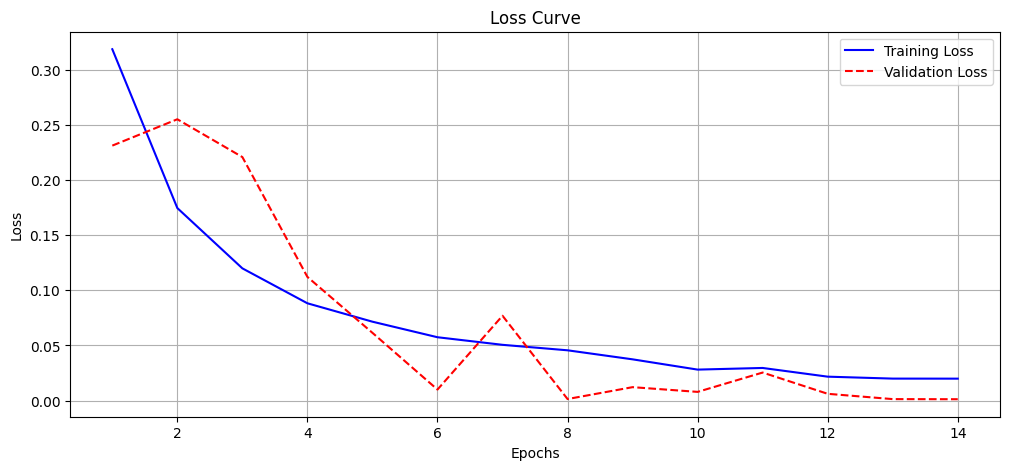

In [155]:
plot_history(train_losses,val_losses)

# 

# Save

In [ ]:
torch.save(model.state_dict(),"best_model_res_28-128_si.pt")

# Cliberation and Temperature Scaling

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def check_calibration(model, dataloader, device='cuda', n_bins=10, plot=True):
    """
    Computes ECE and plots the reliability diagram for a PyTorch model.
    
    Args:
        model: The trained PyTorch model.
        dataloader: Validation or Test loader.
        device: 'cuda' or 'cpu'.
        n_bins: Number of bins for the calibration curve (default 10).
        plot: Whether to show the plot (default True).
        
    Returns:
        ece (float): Expected Calibration Error.
    """
    model.eval()
    model.to(device)
    
    confidences_list = []
    accuracies_list = []
    
    print("Running inference to gather probabilities...")
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 1. Get Logits
            logits = model(inputs)
            
            # 2. Apply Softmax to get probabilities (0.0 to 1.0)
            probs = torch.softmax(logits, dim=1)
            
            # 3. Get the confidence and prediction of the top class
            confidences, predictions = torch.max(probs, dim=1)
            
            # 4. Check if the prediction was actually correct (0 or 1)
            # This turns it into a binary problem: "Did the model get it right?"
            is_correct = (predictions == labels).float()
            
            confidences_list.append(confidences.cpu().numpy())
            accuracies_list.append(is_correct.cpu().numpy())
            
    # Concatenate all batches
    all_confidences = np.concatenate(confidences_list)
    all_accuracies = np.concatenate(accuracies_list)
    
    # --- CALCULATE ECE (Expected Calibration Error) ---
    # We manually group into bins to calculate the weighted average error
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = (all_confidences > bin_lower) & (all_confidences <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = all_accuracies[in_bin].mean()
            avg_confidence_in_bin = all_confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    print(f"\nExpected Calibration Error (ECE): {ece:.4f}")
    if ece > 0.1:
        print("Model is likely poorly calibrated.")
    else:
        print("Model is reasonably calibrated.")

    # --- PLOTTING ---
    if plot:
        # Get coordinates for the plot using sklearn
        prob_true, prob_pred = calibration_curve(all_accuracies, all_confidences, n_bins=n_bins, strategy='uniform')

        plt.figure(figsize=(8, 8))
        
        # Perfect calibration line
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
        
        # Model curve
        plt.plot(prob_pred, prob_true, marker='o', label=f'Model (ECE={ece:.3f})')
        
        plt.xlabel('Average Confidence (Predicted Probability)')
        plt.ylabel('Fraction of Positives (Actual Accuracy)')
        plt.title('Reliability Diagram')
        plt.legend(loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
        
    return ece

In [ ]:
ece_score = check_calibration(model, test_loader, device=device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def get_temperature(logits, labels, device='cuda'):
    """
    Finds the optimal temperature for the model.
    logits: Tensor of raw scores (N x Classes)
    labels: Tensor of true class indices (N)
    """
    # Ensure logits and labels are detached from any previous graph
    logits = logits.detach().to(device)
    labels = labels.detach().to(device)

    # 1. Create the temperature parameter DIRECTLY on the device
    # This ensures it is a 'leaf' tensor
    temperature = nn.Parameter(torch.ones(1, device=device))
    
    # 2. Set up the optimizer (LBFGS is standard for Temperature Scaling)
    optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=50)
    criterion = nn.CrossEntropyLoss()

    # Closure for LBFGS
    def closure():
        optimizer.zero_grad()
        # Apply temperature scaling to logits
        loss = criterion(logits / temperature, labels)
        loss.backward()
        return loss

    # 3. Optimize
    optimizer.step(closure)

    print(f"Optimal Temperature found: {temperature.item():.4f}")
    return temperature.item()

In [ ]:
all_logits = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs.to(device))
        all_logits.append(outputs.cpu())
        all_labels.append(labels.cpu())

# Combine into single tensors
logits_tensor = torch.cat(all_logits)
labels_tensor = torch.cat(all_labels)

# Now find T
T = get_temperature(logits_tensor, labels_tensor, device=device)

# Export : ONNX & TFlite

In [ ]:
!pip install onnx onnx2tf onnxruntime

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# model = TinyRes28(num_classes=4)
# # Update 'best_model.pt' to your actual filename
# model.load_state_dict(torch.load("/kaggle/working/best_model_res_28-128_si.pt", map_location=device))
# model.eval()
# print("Model loaded successfully from graph weights.")

In [ ]:
# Create dummy input
dummy_input = torch.randn(1, 1, 28, 28).to(device)
class ExportModel(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.trained_model = trained_model

    def forward(self, x):
        return self.trained_model(x)  # Force softmax for better INT8 resolution

# Use this to export
model_to_export = ExportModel(model)
torch.onnx.export(model_to_export, dummy_input, 
    "gesture_model.onnx",
    export_params=True,
    opset_version=12,
    input_names=['input'],
    output_names=['output'],
    # ONLY make the batch (dim 0) dynamic. 
    # Do NOT make dim 1, 2, or 3 dynamic.
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)
print(f"Model exported to gesture_model.onnx")

In [ ]:
import tensorflow as tf
import numpy as np
import os

# --- 3a. Convert ONNX to TensorFlow ---
# This command creates a folder named 'saved_model'
!onnx2tf -i gesture_model.onnx -o /kaggle/working/saved_model

def representative_data_gen():
    # 1. Create a temporary loader with shuffle=True and batch_size=1
    # TFLite conversion works best when the representative data batch size is 1
    calib_loader = torch.utils.data.DataLoader(
        train_subset, 
        batch_size=1, 
        shuffle=True
    )
    
    count = 0
    for images, labels in calib_loader:
        if count >= 200: # Use 200 different images
            break
            
        # 2. Extract numpy and ensure it's Float32
        data = images.numpy().astype(np.float32)
        
        # 3. Transpose to NHWC (Batch, Height, Width, Channels)
        # PyTorch [1, 1, 28, 28] -> TF [1, 28, 28, 1]
        data = np.transpose(data, (0, 2, 3, 1))
        
        yield [data]
        count += 1

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Enforce Full Integer Quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Save the final file
with open('gesture_model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

print("Full INT8 TFLite model generated: gesture_model_int8.tflite")

In [ ]:
import tensorflow as tf
import numpy as np

# 1. Load the model to check what shape it actually wants
# This prevents guessing.
interpreter_temp = tf.lite.Interpreter(model_path="saved_model/gesture_model_float32.tflite")
input_details = interpreter_temp.get_input_details()
expected_shape = input_details[0]['shape']
print(f"Model expects input shape: {expected_shape}")


# 3. Setup Converter
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 4. Enforce Full Integer Quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# 5. Conversion
try:
    tflite_model = converter.convert()
    with open('gesture_model_int8.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Success! gesture_model_int8.tflite created.")
except Exception as e:
    print(f"Conversion failed: {e}")